# Playground with sampled data from KiT-RT

### Setup

Note that `moments_conserve` function does not work for this case

In [64]:
using KitBase, Distributions, LinearAlgebra, Flux, Plots
using KitBase.JLD2, KitBase.WriteVTK
using Flux: @epochs

In [75]:
function get_moments(f, u, v, ω)
    w = zeros(eltype(f), 4)
    w[1] = discrete_moments(f, u, ω, 0)
    w[2] = discrete_moments(f, u, ω, 1)
    w[3] = discrete_moments(f, v, ω, 1)
    w[4] = 0.5 * (discrete_moments(f, u, ω, 2) + discrete_moments(f, v, ω, 2))
    return w
end

function regime_data(w, swx, swy, f, u, v, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 2)
    prim = conserve_prim(w, gam)
    Mu, Mv, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, swx, K)
    b = pdf_slope(prim, swy, K)
    swt = -prim[1] .* (moments_conserve_slope(a, Mu, Mv, Mxi, 1, 0) .+ moments_conserve_slope(b, Mu, Mv, Mxi, 0, 1))
    A = pdf_slope(prim, swt, K)
    
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, v, prim, a, b, A, tau)
    L = norm((f .- fr) ./ prim[1])
    sw = (swx.^2 + swy.^2).^0.5
    x = [w; sw; tau]
    y = ifelse(L <= 0.005, 0.0, 1.0)
    return x, y
end

function regime_number(Y, rg=0)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Z)
    Z1 = nn(X)

    ZA1 = [round(Z1[1, i]) for i in axes(Z1, 2)]
    ZA = [round(Z[1, i]) for i in axes(Z, 2)]

    accuracy = 0.0
    for i in eachindex(ZA)
        if ZA[i] == ZA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(ZA)

    return accuracy
end

function train_data!(X, Y, pdfs, vs, rhos, dxs, dys, kns)
    nd = length(pdfs) ÷ 2
    
    for i = 1:nd÷2
        try
            fL = pop!(pdfs) .* pop!(rhos); fR = pop!(pdfs) .* pop!(rhos) # shuffle
            wL = get_moments(fL, vs.u, vs.v, vs.weights); wR = get_moments(fR, vs.u, vs.v, vs.weights)

            δx, δy = dxs[i], dys[i]
            n = [δx, δy] ./ norm([δx, δy])
            vn = vs.u .* n[1] .+ vs.v .* n[2]
            vt = vs.v .* n[1] .- vs.u .* n[2]
            δ = heaviside.(vn)
            f = @. fL * δ + fR * (1.0 - δ)
            w = get_moments(f, vs.u, vs.v, vs.weights)

            swx = @. (wR - wL) / δx
            swy = @. (wR - wL) / δy

            tmpx, tmpy = regime_data(w, swx, swy, f, vs.u, vs.v, 0, kns[i])
            X = hcat(X, tmpx)
            Y = hcat(Y, tmpy)
        catch
            println("error at ($i)-th data")
        end
    end
    
    return X, Y
end

train_data! (generic function with 1 method)

In [76]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/a2_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[5:end]
nd = length(pdfs) ÷ 2

nqa = sqrt(length(data[1])) |> Int
vs = VSpace2D(-5.0, 5.0, nqa, -5.0, 5.0, nqa, data[1], data[2], zero(data[1]), zero(data[2]), data[4])

VelocitySpace2D{Float64,Int64,Vector{Float64}}
domain: (-5.0,5.0) × (-5.0,5.0)
resolution: 80 × 80
ghost in u: 0
ghost in v: 0


In [77]:
dist = Uniform(0.005, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.005, 0.1)
dys = rand(dist, nd)
dist = Uniform(0.0001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.2, 2.0)
rhos = rand(dist, nd); rhos .= 1;

X = Float32[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Y = Float32[0.0]
X, Y = train_data!(X, Y, pdfs, vs, rhos, dxs, dys, kns)

([1.0 1.0000000000001563 … 1.0000000000002656 0.9999999999993594; 0.0 -0.000621574733302821 … -0.00034250224175486066 -0.0011878616170770684; … ; 0.0 0.00023038403189935686 … 0.0007993224489506565 0.0009079004331068116; 1.0 0.5968474936641999 … 0.8239895035523084 0.7826932306995438], [0.0 0.0 … 0.0 0.0])

In [79]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/a2_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[5:end]

dist = Uniform(0.005, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.005, 0.1)
dys = rand(dist, nd)
dist = Uniform(0.0001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.2, 2.0)
rhos = rand(dist, nd);

X, Y = train_data!(X, Y, pdfs, vs, rhos, dxs, dys, kns)

([1.0 1.0000000000001563 … 1.5093991010246628 1.370729871268447; 0.0 -0.000621574733302821 … -0.256546669003203 -0.04203405883163147; … ; 0.0 0.00023038403189935686 … 24.502816179717723 82.85060683951221; 1.0 0.5968474936641999 … 0.4346650618549413 0.39660154991161073], [0.0 0.0 … 1.0 1.0])

In [81]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/a3_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[5:end]

dist = Uniform(0.005, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.005, 0.1)
dys = rand(dist, nd)
dist = Uniform(0.0001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.2, 2.0)
rhos = rand(dist, nd);

X, Y = train_data!(X, Y, pdfs, vs, rhos, dxs, dys, kns)

([1.0 1.0000000000001563 … 0.8802006052811322 0.3084091397312956; 0.0 -0.000621574733302821 … 0.23681163305246816 -0.009837700286520423; … ; 0.0 0.00023038403189935686 … 16.066284021964282 1.0676934688878912; 1.0 0.5968474936641999 … 0.4097817158634713 0.061065764785933445], [0.0 0.0 … 1.0 1.0])

In [82]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/a4_ev5.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[5:end]

dist = Uniform(0.005, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.005, 0.1)
dys = rand(dist, nd)
dist = Uniform(0.0001, 1.0)
kns = rand(dist, nd);
dist = Uniform(0.2, 2.0)
rhos = rand(dist, nd);

X, Y = train_data!(X, Y, pdfs, vs, rhos, dxs, dys, kns)

([1.0 1.0000000000001563 … 1.1129138740531184 1.313191259147852; 0.0 -0.000621574733302821 … 0.045584340274769986 0.13356913242008217; … ; 0.0 0.00023038403189935686 … 5.713211253485335 9.720096727507714; 1.0 0.5968474936641999 … 0.4007480754630404 0.5505203275754268], [0.0 0.0 … 1.0 1.0])

In [83]:
X

9×10001 Matrix{Float64}:
 1.0   1.0           1.0          …   0.563528  1.11291    1.31319
 0.0  -0.000621575  -0.00095065       0.152587  0.0455843  0.133569
 0.0  -0.000350458  -0.000467871      0.188831  0.0639478  0.171852
 1.0   1.84372       1.84372          0.708025  1.46524    1.61603
 0.0   1.54073e-11   1.11573e-11      8.47712   3.39079    9.95527
 0.0   1.95524e-15   1.98388e-15  …   0.177642  0.586326   0.0139364
 0.0   2.10036e-17   5.81214e-17      0.154885  0.0350203  0.716635
 0.0   0.000230384   0.00016585      11.1956    5.71321    9.7201
 1.0   0.596847      0.221573         1.64218   0.400748   0.55052

In [84]:
regime_number(Y)

NS regime: 1600 of 10001


### Model

In [85]:
device = cpu

cpu (generic function with 1 method)

In [86]:
#isNewStart = true
isNewStart = false

if isNewStart
    nn = Chain(
        Dense(9, 36, sigmoid),
        Dense(36, 72, sigmoid),
        Dense(72, 36, sigmoid),
        Dense(36, 1, sigmoid),
    )
else
    @load "../nn_scalar.jld2" nn
end

1-element Vector{Symbol}:
 :nn

In [87]:
data = Flux.Data.DataLoader((Float32.(X), Float32.(Y)), shuffle = true)
ps = Flux.params(nn)
sqnorm(x) = sum(abs2, x)
loss(x, y) = Flux.binarycrossentropy(nn(x), y)
cb = () -> println("loss: $(loss(X, Y))")
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [88]:
@epochs 10 Flux.train!(loss, ps, data, opt, cb = Flux.throttle(cb, 1))

┌ Info: Epoch 1
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 1.6208358903641034
loss: 0.19796660310063025
loss: 0.18694576203479252


┌ Info: Epoch 2
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.17235145795736073
loss: 0.17161638693133993


┌ Info: Epoch 3
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.17018297221435355
loss: 0.1710881741609947


┌ Info: Epoch 4
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1703052669543337
loss: 0.1696761709150122


┌ Info: Epoch 5
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.17225792113270905
loss: 0.16836685981215796


┌ Info: Epoch 6
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1683586237686094
loss: 0.17104133495159923


┌ Info: Epoch 7
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.16897715091682572
loss: 0.16877802909604098


┌ Info: Epoch 8
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.1690603966558223


┌ Info: Epoch 9
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.16758720583860034
loss: 0.16896995001545223
loss: 0.1690364169573358


┌ Info: Epoch 10
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.16903012255331648


### Test

In [63]:
accuracy(nn, X, Y)

0.8708258348330334

### Postprocess

In [ ]:
cd(@__DIR__)
@save "nn_rif.jld2" nn

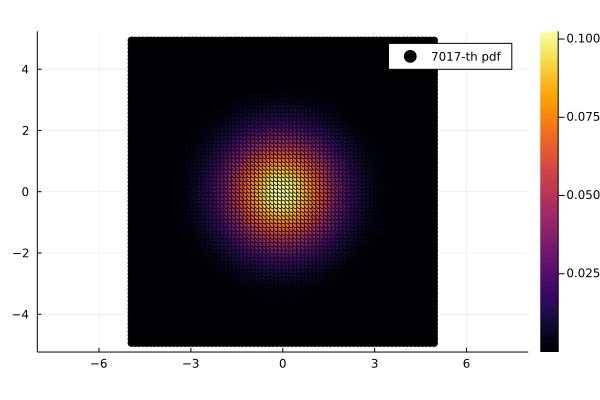

In [11]:
idx = rand() * length(data) |> floor |> Int
scatter(vs.u, vs.v, marker_z=data[idx], legend=true, ratio=1, label="$(idx)-th pdf") # colored scatter plot